# Import Necessary Libraries

In [12]:
import jsonlines
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
from seqeval.metrics import classification_report, precision_score, recall_score, f1_score
from seqeval.scheme import IOB2
import spacy
from spacy.training.example import Example
from spacy.util import minibatch, compounding
from spacy.training.iob_utils import offsets_to_biluo_tags
import random
import json
import os
from tqdm import tqdm

# Reading The Data

In [16]:
def read_jsonl_file(file_path):
    data = []
    with jsonlines.open(file_path) as reader:
        for line in reader:
            data.append(line)
    return data

In [17]:
file_path = "Final_augmented_data.jsonl"
test1 = read_jsonl_file(file_path)
text3 = []
spans3 = []
for entry in test1:
    if entry['text'] not in text3:
        text3.append(entry["text"])
        spans3.append(entry['entities']) 

In [18]:
print(len(text3))
print(len(spans3))

2582
2582


100%|██████████| 2582/2582 [00:20<00:00, 126.02it/s]


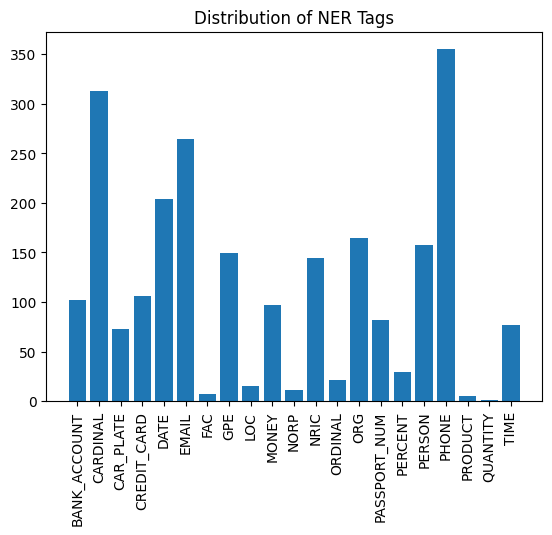

In [19]:
def read_jsonl_file(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

def check_overlap(spans, new_span):
    for start, end in spans:
        if new_span[0] <= end and new_span[1] >= start:
            return True
    return False

def is_valid_span(span):
    return (
        isinstance(span, list) and 
        len(span) == 3 and 
        isinstance(span[0], int) and 
        isinstance(span[1], int) and 
        isinstance(span[2], str)
    )

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Read the JSONL file
file_path = "Final_augmented_data.jsonl"
data = read_jsonl_file(file_path)

text3 = []
spans3 = []
for entry in data:
    if entry['text'] not in text3:
        text3.append(entry["text"])
        spans3.append(entry['entities'])

processed_texts = []
processed_spans = []

for i in tqdm(range(len(text3))):
    doc = nlp(text3[i])
    temp_spans = []
    overlap_check_spans = []

    for j in spans3[i]:
        if not is_valid_span(j):
            print(f"ERROR at i = {i}: Invalid entry format in spans3[{i}]")
            continue
        try:
            start_char = j[0]
            end_char = j[1]
            label = j[2]
            if not check_overlap(overlap_check_spans, (start_char, end_char)):
                temp_spans.append({'start': start_char, 'end': end_char, 'label': label})
                overlap_check_spans.append((start_char, end_char))
        except Exception as e:
            print(f"ERROR at i = {i}, entity = {j}: {e}")

    processed_texts.append(text3[i])
    processed_spans.append(temp_spans)

# Update spans with processed_spans for further analysis
spans = processed_spans

# Counting the Labels
labels = {}
for i in spans:
    for j in i:
        labels[j['label']] = labels.get(j['label'], 0) + 1

labels = dict(sorted(labels.items(), key=lambda item: item[0]))
plt.bar(labels.keys(), labels.values())
plt.xticks(rotation = 90)
plt.title("Distribution of NER Tags")
plt.show()

In [86]:
label_list = []
for key, value in labels.items():
    if value > 30:
        label_list.append(key)

label_list

['BANK_ACCOUNT',
 'CARDINAL',
 'CAR_PLATE',
 'CREDIT_CARD',
 'DATE',
 'EMAIL',
 'GPE',
 'MONEY',
 'NRIC',
 'ORG',
 'PASSPORT_NUM',
 'PERSON',
 'PHONE',
 'TIME']

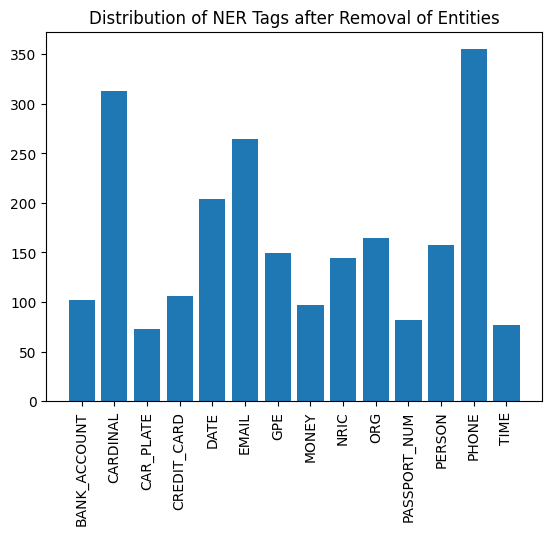

In [87]:
# Removal of Entities with Less Representation
spans2 = []
for i in range(len(spans)):
    temp = []
    for j in spans[i]:
        if j['label'] in label_list:
            temp.append(j)
    spans2.append(temp)

# Counting the Labels after removal of Entities
labels2 = {}
for i in spans2:
    for j in i:
        labels2[j['label']] = labels2.get(j['label'], 0) + 1

labels2 = dict(sorted(labels2.items(), key=lambda item: item[0]))
plt.bar(labels2.keys(), labels2.values())
plt.xticks(rotation = 90)
plt.title("Distribution of NER Tags after Removal of Entities")
plt.show()

In [88]:
merged_train, merged_test = train_test_split(text3, test_size=0.2, random_state=1)

In [94]:
X_train = []
y_train = []
X_test = []
y_test = []
for i in text3:
    if i in merged_test:
        X_test.append(i)
        y_test.append(spans2[text3.index(i)])
    else:
        X_train.append(i)
        y_train.append(spans2[text3.index(i)])

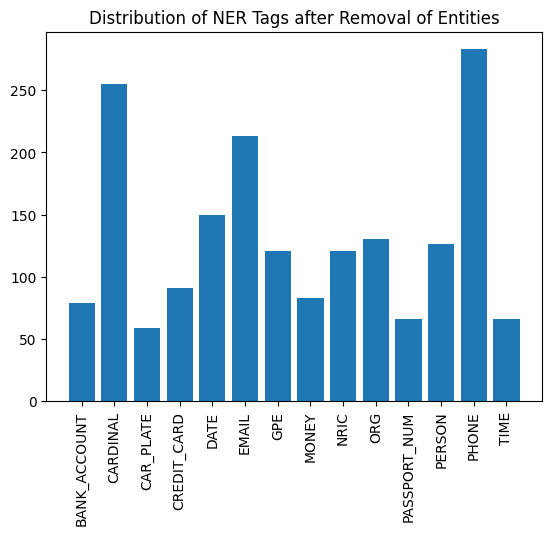

In [95]:
# Count of Labels for Train Set
labels3 = {}
for i in y_train:
    for j in i:
        labels3[j['label']] = labels3.get(j['label'], 0) + 1

labels3 = dict(sorted(labels3.items(), key=lambda item: item[0]))
plt.bar(labels3.keys(), labels3.values())
plt.xticks(rotation = 90)
plt.title("Distribution of NER Tags after Removal of Entities")
plt.show()

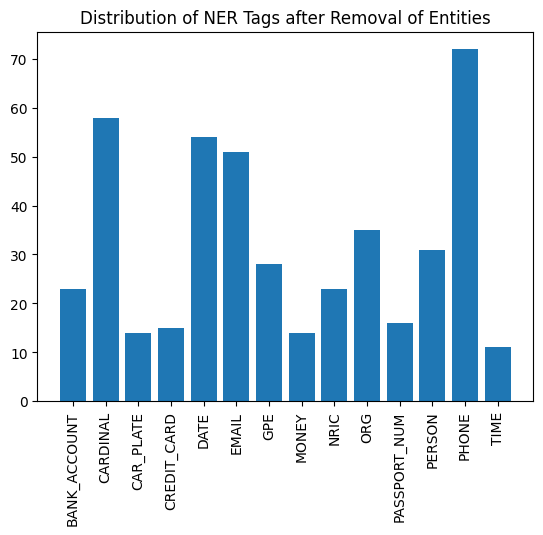

In [96]:
# Count of Labels for Test Set
labels4 = {}
for i in y_test:
    for j in i:
        labels4[j['label']] = labels4.get(j['label'], 0) + 1

labels4 = dict(sorted(labels4.items(), key=lambda item: item[0]))
plt.bar(labels4.keys(), labels4.values())
plt.xticks(rotation = 90)
plt.title("Distribution of NER Tags after Removal of Entities")
plt.show()

In [97]:
train_data = []
for i in range(len(X_train)):
    temp2 = []
    for j in y_train[i]:
        if (j['start'], j['end'], j['label']) not in temp2:
            temp2.append((j['start'], j['end'], j['label']))
    temp = (X_train[i], {"entities" : temp2}) 
    train_data.append(temp)

In [93]:
test_data1 = []
for i in range(len(X_test)):
    temp2 = []
    for j in y_test[i]:
        temp2.append((j['start'], j['end'], j['label']))
    
    temp = (X_test[i], {"entities" : temp2}) 
    test_data1.append(temp)

# Training

In [98]:
# Function to fix misaligned entities
def fix_misaligned_entities(text, entities):
    doc = nlp.make_doc(text)
    tags = offsets_to_biluo_tags(doc, entities)
    fixed_entities = []
    current_entity = None

    for token, tag in zip(doc, tags):
        if tag.startswith('B'):
            if current_entity:
                fixed_entities.append(current_entity)
            current_entity = [token.idx, token.idx + len(token), tag.split('-')[-1]]
        elif tag.startswith('I') and current_entity:
            current_entity[1] = token.idx + len(token)
        elif tag.startswith('L') and current_entity:
            current_entity[1] = token.idx + len(token)
            fixed_entities.append(current_entity)
            current_entity = None
        elif tag.startswith('U'):
            if current_entity:
                fixed_entities.append(current_entity)
            current_entity = [token.idx, token.idx + len(token), tag.split('-')[-1]]
            fixed_entities.append(current_entity)
            current_entity = None
        else:
            if current_entity:
                fixed_entities.append(current_entity)
                current_entity = None

    if current_entity:
        fixed_entities.append(current_entity)
    
    return {"entities": fixed_entities}

# Initialize a blank spacy model
nlp = spacy.blank("en")

# Add the NER component to the pipeline
if "ner" not in nlp.pipe_names:
    nlp.add_pipe("ner", last=True)

# Add entity labels to the NER component
ner = nlp.get_pipe("ner")
for _, annotations in train_data:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

# Fix misaligned entities in training data
corrected_train_data = []
for text, annotations in train_data:
    corrected_annotations = fix_misaligned_entities(text, annotations["entities"])
    corrected_train_data.append((text, corrected_annotations))

# Begin training the model
optimizer = nlp.begin_training()
for itn in tqdm(range(100)):
    losses = {}
    for text, annotations in corrected_train_data:
        doc = nlp.make_doc(text)
        example = Example.from_dict(doc, annotations)
        nlp.update([example], drop=0.5, sgd=optimizer, losses=losses)
    print(losses)

  1%|          | 1/100 [01:12<1:59:38, 72.51s/it]

{'ner': 3657.9678126439803}


  2%|▏         | 2/100 [02:26<1:59:25, 73.12s/it]

{'ner': 3288.7538541962986}


  3%|▎         | 3/100 [03:35<1:55:27, 71.42s/it]

{'ner': 3261.878694891656}


  4%|▍         | 4/100 [04:44<1:52:50, 70.52s/it]

{'ner': 2992.7647413424775}


  5%|▌         | 5/100 [05:53<1:50:38, 69.87s/it]

{'ner': 3146.416803723211}


  6%|▌         | 6/100 [07:01<1:48:48, 69.46s/it]

{'ner': 2841.333308975809}


  7%|▋         | 7/100 [08:10<1:47:12, 69.17s/it]

{'ner': 3035.396821446167}


  8%|▊         | 8/100 [09:20<1:46:40, 69.57s/it]

{'ner': 2745.939345563009}


  9%|▉         | 9/100 [10:29<1:45:10, 69.35s/it]

{'ner': 2619.427179046385}


 10%|█         | 10/100 [11:38<1:43:45, 69.17s/it]

{'ner': 2686.1685517088986}


 11%|█         | 11/100 [12:48<1:43:04, 69.49s/it]

{'ner': 2648.474320847635}


 12%|█▏        | 12/100 [13:59<1:42:26, 69.85s/it]

{'ner': 2442.6149834788566}


 13%|█▎        | 13/100 [15:08<1:40:52, 69.57s/it]

{'ner': 2278.1862783709544}


 14%|█▍        | 14/100 [16:18<1:39:56, 69.72s/it]

{'ner': 2407.720877371308}


 15%|█▌        | 15/100 [17:28<1:39:01, 69.90s/it]

{'ner': 2396.574442962516}


 16%|█▌        | 16/100 [18:40<1:38:33, 70.40s/it]

{'ner': 2077.2050489907065}


 17%|█▋        | 17/100 [19:54<1:38:57, 71.53s/it]

{'ner': 2184.221280539695}


 18%|█▊        | 18/100 [21:07<1:38:14, 71.89s/it]

{'ner': 2050.3315903195303}


 19%|█▉        | 19/100 [22:18<1:36:39, 71.60s/it]

{'ner': 1916.8243123739649}


 20%|██        | 20/100 [23:29<1:35:31, 71.64s/it]

{'ner': 1981.927501619735}


 21%|██        | 21/100 [24:40<1:33:58, 71.37s/it]

{'ner': 1897.8632373449132}


 22%|██▏       | 22/100 [25:52<1:32:58, 71.52s/it]

{'ner': 1679.739846675488}


 23%|██▎       | 23/100 [27:04<1:31:48, 71.54s/it]

{'ner': 1813.190878178761}


 24%|██▍       | 24/100 [28:15<1:30:26, 71.40s/it]

{'ner': 1903.8604464781981}


 25%|██▌       | 25/100 [29:26<1:29:04, 71.25s/it]

{'ner': 1879.7641281346318}


 26%|██▌       | 26/100 [30:35<1:27:15, 70.75s/it]

{'ner': 1772.2912516906179}


 27%|██▋       | 27/100 [31:46<1:26:06, 70.77s/it]

{'ner': 1816.6670083700647}


 28%|██▊       | 28/100 [32:57<1:25:08, 70.95s/it]

{'ner': 1718.4199668321937}


 29%|██▉       | 29/100 [34:11<1:24:57, 71.80s/it]

{'ner': 1689.515635736293}


 30%|███       | 30/100 [35:32<1:26:56, 74.52s/it]

{'ner': 1610.646813018239}


 31%|███       | 31/100 [36:45<1:25:04, 73.97s/it]

{'ner': 1560.6033651613418}


 32%|███▏      | 32/100 [37:57<1:23:11, 73.41s/it]

{'ner': 1529.0596762350676}


 33%|███▎      | 33/100 [39:07<1:21:01, 72.57s/it]

{'ner': 1710.5797248672159}


 34%|███▍      | 34/100 [40:19<1:19:22, 72.16s/it]

{'ner': 1598.949482990712}


 35%|███▌      | 35/100 [41:31<1:18:07, 72.12s/it]

{'ner': 1614.4675974131196}


 36%|███▌      | 36/100 [42:42<1:16:45, 71.95s/it]

{'ner': 1534.1148633743842}


 37%|███▋      | 37/100 [43:57<1:16:29, 72.85s/it]

{'ner': 1613.2172592675777}


 38%|███▊      | 38/100 [45:10<1:15:20, 72.91s/it]

{'ner': 1482.672481895861}


 39%|███▉      | 39/100 [46:23<1:13:58, 72.75s/it]

{'ner': 1547.8324367499606}


 40%|████      | 40/100 [47:34<1:12:20, 72.35s/it]

{'ner': 1550.8262027872174}


 41%|████      | 41/100 [48:46<1:10:56, 72.15s/it]

{'ner': 1577.211036982632}


 42%|████▏     | 42/100 [49:58<1:09:47, 72.20s/it]

{'ner': 1525.3375880294498}


 43%|████▎     | 43/100 [51:11<1:08:47, 72.41s/it]

{'ner': 1499.04278740584}


 44%|████▍     | 44/100 [52:23<1:07:29, 72.30s/it]

{'ner': 1526.3870458524095}


 45%|████▌     | 45/100 [53:35<1:06:11, 72.20s/it]

{'ner': 1625.3885770521258}


 46%|████▌     | 46/100 [54:47<1:04:58, 72.20s/it]

{'ner': 1676.2389281087626}


 47%|████▋     | 47/100 [56:02<1:04:35, 73.11s/it]

{'ner': 1617.5824690038162}


 48%|████▊     | 48/100 [57:13<1:02:50, 72.52s/it]

{'ner': 1785.8623442872058}


 49%|████▉     | 49/100 [58:25<1:01:17, 72.11s/it]

{'ner': 1431.3585988624154}


 50%|█████     | 50/100 [59:37<1:00:09, 72.20s/it]

{'ner': 1479.4643185057462}


 51%|█████     | 51/100 [1:00:48<58:35, 71.75s/it]

{'ner': 1490.3944909395807}


 52%|█████▏    | 52/100 [1:02:01<57:47, 72.24s/it]

{'ner': 1439.227790638477}


 53%|█████▎    | 53/100 [1:03:16<57:06, 72.90s/it]

{'ner': 1561.102967657913}


 54%|█████▍    | 54/100 [1:04:28<55:40, 72.62s/it]

{'ner': 1409.0950746883293}


 55%|█████▌    | 55/100 [1:05:38<53:54, 71.87s/it]

{'ner': 1498.7820374124603}


 56%|█████▌    | 56/100 [1:06:48<52:23, 71.44s/it]

{'ner': 1461.7499105655934}


 57%|█████▋    | 57/100 [1:07:58<50:55, 71.05s/it]

{'ner': 1517.3268167083233}


 58%|█████▊    | 58/100 [1:09:08<49:26, 70.63s/it]

{'ner': 1429.6241995564394}


 59%|█████▉    | 59/100 [1:10:17<48:03, 70.32s/it]

{'ner': 1514.5173181996386}


 60%|██████    | 60/100 [1:11:27<46:41, 70.04s/it]

{'ner': 1521.8609589680286}


 61%|██████    | 61/100 [1:12:37<45:27, 69.95s/it]

{'ner': 1350.9969240377131}


 62%|██████▏   | 62/100 [1:13:46<44:13, 69.84s/it]

{'ner': 1418.5542135530454}


 63%|██████▎   | 63/100 [1:14:55<42:54, 69.59s/it]

{'ner': 1568.822871630919}


 64%|██████▍   | 64/100 [1:16:04<41:38, 69.40s/it]

{'ner': 1512.646953984163}


 65%|██████▌   | 65/100 [1:17:13<40:25, 69.30s/it]

{'ner': 1533.0185120485003}


 66%|██████▌   | 66/100 [1:18:22<39:14, 69.24s/it]

{'ner': 1459.0043615292402}


 67%|██████▋   | 67/100 [1:19:32<38:05, 69.26s/it]

{'ner': 1390.9008409239052}


 68%|██████▊   | 68/100 [1:20:41<36:54, 69.21s/it]

{'ner': 1406.093599948505}


 69%|██████▉   | 69/100 [1:21:49<35:39, 69.02s/it]

{'ner': 1535.6018559965673}


 70%|███████   | 70/100 [1:22:58<34:30, 69.03s/it]

{'ner': 1532.6441770384572}


 71%|███████   | 71/100 [1:24:07<33:19, 68.95s/it]

{'ner': 1320.7052359794802}


 72%|███████▏  | 72/100 [1:25:17<32:14, 69.10s/it]

{'ner': 1356.7831175021913}


 73%|███████▎  | 73/100 [1:26:26<31:08, 69.21s/it]

{'ner': 1394.729380473137}


 74%|███████▍  | 74/100 [1:27:35<29:58, 69.19s/it]

{'ner': 1359.3599122113064}


 75%|███████▌  | 75/100 [1:28:45<28:53, 69.33s/it]

{'ner': 1398.007951811616}


 76%|███████▌  | 76/100 [1:29:54<27:44, 69.35s/it]

{'ner': 1386.470005633349}


 77%|███████▋  | 77/100 [1:31:03<26:32, 69.22s/it]

{'ner': 1446.5108757555493}


 78%|███████▊  | 78/100 [1:32:13<25:27, 69.43s/it]

{'ner': 1302.3550621258025}


 79%|███████▉  | 79/100 [1:33:23<24:20, 69.55s/it]

{'ner': 1268.0762524604563}


 80%|████████  | 80/100 [1:34:34<23:19, 70.00s/it]

{'ner': 1293.1064210492245}


 81%|████████  | 81/100 [1:35:46<22:21, 70.63s/it]

{'ner': 1394.729944606803}


 82%|████████▏ | 82/100 [1:36:59<21:26, 71.47s/it]

{'ner': 1401.554659991669}


 83%|████████▎ | 83/100 [1:38:13<20:24, 72.04s/it]

{'ner': 1295.9317673969479}


 84%|████████▍ | 84/100 [1:39:28<19:27, 72.99s/it]

{'ner': 1413.354464380467}


 85%|████████▌ | 85/100 [1:40:47<18:40, 74.71s/it]

{'ner': 1418.6781987585302}


 86%|████████▌ | 86/100 [1:42:03<17:31, 75.09s/it]

{'ner': 1394.6037987278985}


 87%|████████▋ | 87/100 [1:43:17<16:11, 74.72s/it]

{'ner': 1365.147131110305}


 88%|████████▊ | 88/100 [1:44:30<14:52, 74.41s/it]

{'ner': 1312.656236892848}


 89%|████████▉ | 89/100 [1:45:45<13:39, 74.47s/it]

{'ner': 1259.9850044091322}


 90%|█████████ | 90/100 [1:46:59<12:23, 74.30s/it]

{'ner': 1272.647447868077}


 91%|█████████ | 91/100 [1:48:14<11:10, 74.46s/it]

{'ner': 1196.6272662106087}


 92%|█████████▏| 92/100 [1:49:29<09:56, 74.61s/it]

{'ner': 1206.5363592132885}


 93%|█████████▎| 93/100 [1:50:43<08:42, 74.58s/it]

{'ner': 1351.6116920432587}


 94%|█████████▍| 94/100 [1:51:58<07:27, 74.60s/it]

{'ner': 1201.6678148169494}


 95%|█████████▌| 95/100 [1:53:12<06:11, 74.39s/it]

{'ner': 1246.8443908524657}


 96%|█████████▌| 96/100 [1:54:28<05:00, 75.08s/it]

{'ner': 1214.5248070866946}


 97%|█████████▋| 97/100 [1:55:44<03:45, 75.31s/it]

{'ner': 1196.370729898814}


 98%|█████████▊| 98/100 [1:56:59<02:30, 75.29s/it]

{'ner': 1270.0497403825163}


 99%|█████████▉| 99/100 [1:58:15<01:15, 75.24s/it]

{'ner': 1276.706373008859}


100%|██████████| 100/100 [1:59:29<00:00, 71.70s/it]

{'ner': 1208.212004727767}


In [99]:
current_directory = os.getcwd()
save_path = os.path.join(current_directory, "ner_model_temp")
nlp.to_disk(save_path)

In [100]:
X_test = []
y_test = []
with open('Final_test_data.jsonl', 'r') as file:
    for line in file:
        obj = json.loads(line)
        X_test.append(obj['text'])
        entities_transformed = [{'start': entity[0], 'end': entity[1], 'label': entity[2]} for entity in obj['entities']]
        y_test.append(entities_transformed)

test_data1 = []
for i in range(len(X_test)):
    temp2 = []
    for j in y_test[i]:
        temp2.append((j['start'], j['end'], j['label']))
    
    temp = (X_test[i], {"entities" : temp2}) 
    test_data1.append(temp)

# F1-Score

In [101]:
nlp = spacy.load("ner_model_temp")
gold_annotations = []
for i in test_data1:
    gold_annotations.append(i[1])
predicted_annotations = []
for inst in test_data1:
    doc = nlp(inst[0])
    entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
    predicted_annotations.append({"entities": entities})

In [102]:
# Function to determine the length of the text
def get_text_length(annotation):
    # Determine the maximum index used in the entity annotations
    if annotation['entities']:
        return max(end for _, end, _ in annotation['entities'])
    return 0

# Convert annotations to BIO format
def annotations_to_bio(annotation, text_length, labels_of_interest):
    bio_labels = ['O'] * text_length
    for start, end, label in annotation['entities']:
        if label in labels_of_interest:
            bio_labels[start] = f'B-{label}'
            for i in range(start + 1, end):
                bio_labels[i] = f'I-{label}'
    return bio_labels

# Define the labels you're interested in
labels_of_interest = ['BANK_ACCOUNT', 'CAR_PLATE', 'CREDIT_CARD', 'EMAIL', 'NRIC', 'PASSPORT_NUM', 'PHONE']

# Convert annotations to BIO format for each text
gold_labels = []
predicted_labels = []

for gold, pred in zip(gold_annotations, predicted_annotations):
    gold_text_length = get_text_length(gold)
    pred_text_length = get_text_length(pred)
    
    # Ensure both lengths are the same for each corresponding pair
    text_length = max(gold_text_length, pred_text_length)
    
    gold_labels.append(annotations_to_bio(gold, text_length, labels_of_interest))
    predicted_labels.append(annotations_to_bio(pred, text_length, labels_of_interest))

# Calculate metrics using seqeval
report = classification_report(gold_labels, predicted_labels, output_dict=True, mode='strict', scheme=IOB2)
precision = precision_score(gold_labels, predicted_labels, mode='strict', scheme=IOB2)
recall = recall_score(gold_labels, predicted_labels, mode='strict', scheme=IOB2)
f1 = f1_score(gold_labels, predicted_labels, mode='strict', scheme=IOB2)

# Convert classification report to DataFrame
df_report = pd.DataFrame(report).transpose()

print(df_report)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
    

              precision    recall  f1-score  support
BANK_ACCOUNT   0.846154  0.733333  0.785714     15.0
CAR_PLATE      0.875000  0.736842  0.800000     19.0
CREDIT_CARD    0.777778  0.636364  0.700000     11.0
EMAIL          0.965517  0.800000  0.875000     35.0
NRIC           0.923077  0.545455  0.685714     22.0
PASSPORT_NUM   0.809524  0.894737  0.850000     19.0
PHONE          0.750000  0.857143  0.800000     28.0
micro avg      0.849624  0.758389  0.801418    149.0
macro avg      0.849579  0.743410  0.785204    149.0
weighted avg   0.861440  0.758389  0.798298    149.0
Precision: 0.849624060150376
Recall: 0.7583892617449665
F1-score: 0.8014184397163121


# Other Metrices

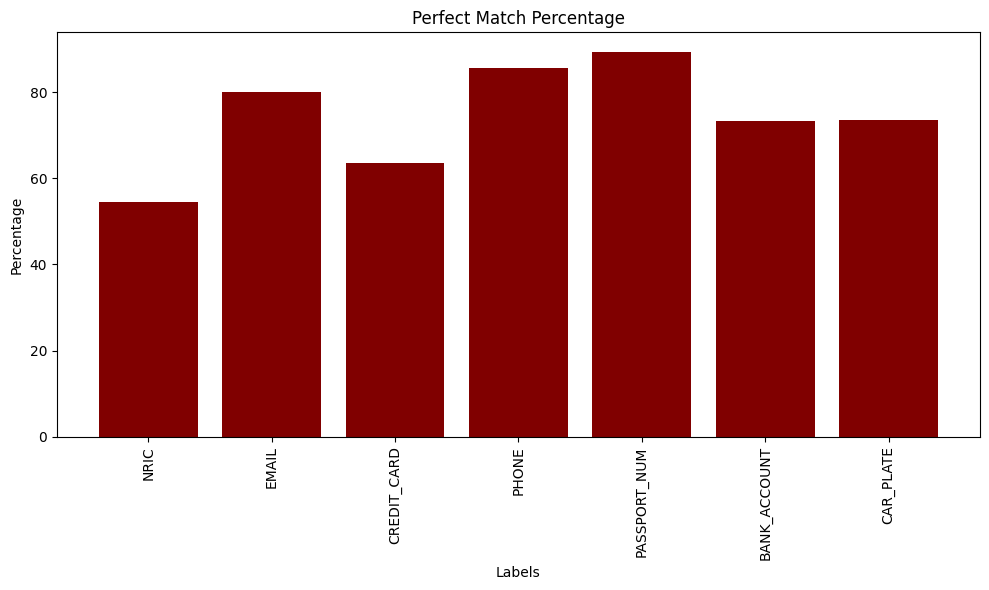

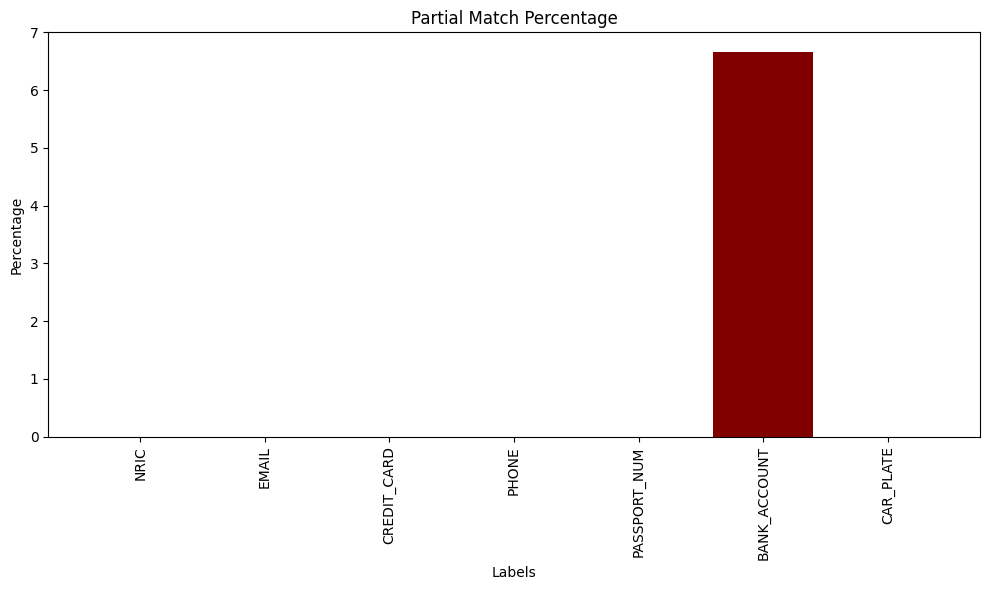

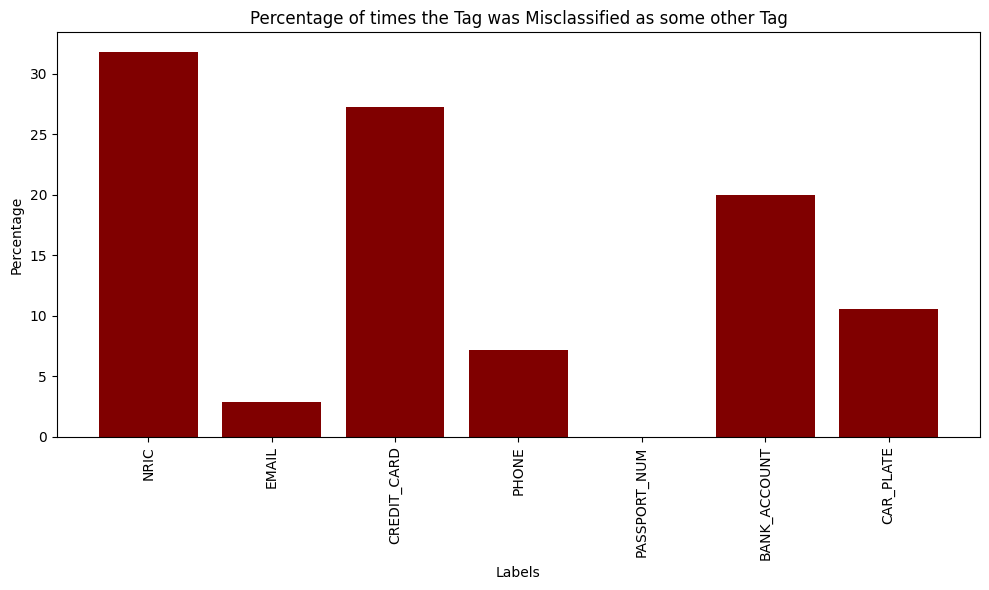

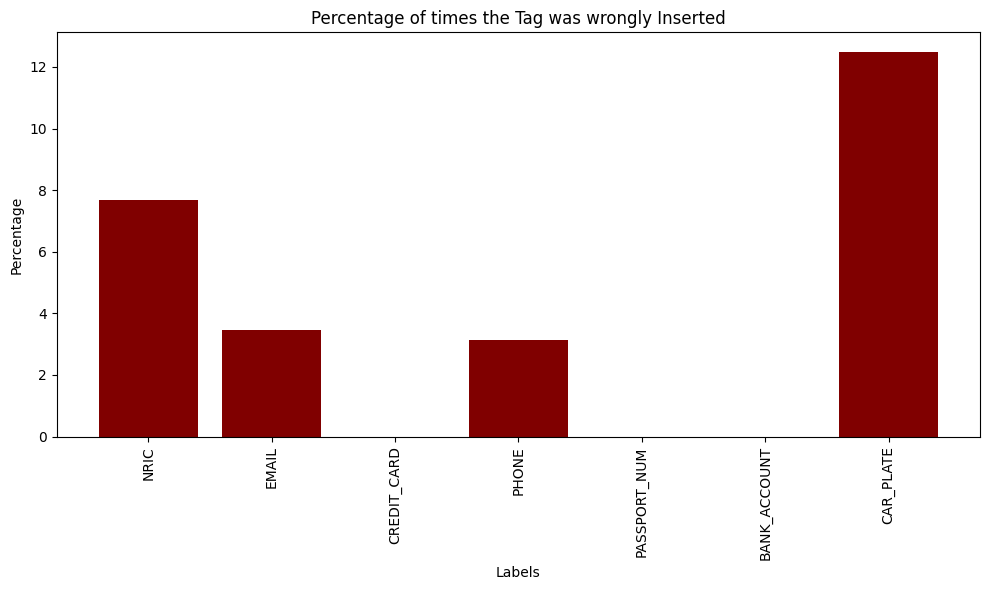

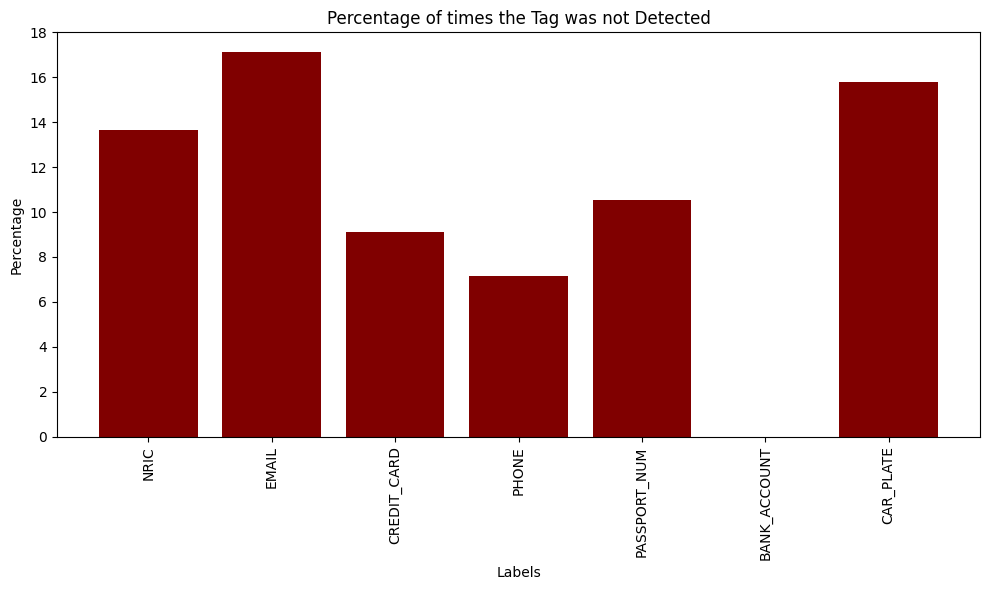

,Tag,Perfect (%),Part (%),Substituted (%),Hallucinated (%),Omitted (%)
0,NRIC,54.545455,0.000000,31.818182,7.692308,13.636364
1,EMAIL,80.000000,0.000000,2.857143,3.448276,17.142857
2,CREDIT_CARD,63.636364,0.000000,27.272727,0.000000,9.090909
3,PHONE,85.714286,0.000000,7.142857,3.125000,7.142857
4,PASSPORT_NUM,89.473684,0.000000,0.000000,0.000000,10.526316
5,BANK_ACCOUNT,73.333333,6.666667,20.000000,0.000000,0.000000
6,CAR_PLATE,73.684211,0.000000,10.526316,12.500000,15.789474


In [103]:
# Define a function to create an empty dictionary with keys from a list
def empty_dict(l):
    return {i: 0 for i in l}
# Load the NER model
nlp = spacy.load("ner_model_temp")

# Extract gold and predicted annotations
gold_annotations = [i[1] for i in test_data1]
predicted_annotations = []
for inst in test_data1:
    doc = nlp(inst[0])
    entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
    predicted_annotations.append({"entities": entities})

# Define relevant entities
relevant_entities = ["NRIC", "EMAIL", "CREDIT_CARD", "PHONE", "PASSPORT_NUM", "BANK_ACCOUNT", "CAR_PLATE"]

# Initialize dictionaries for performance metrics
perf_match = empty_dict(relevant_entities)
part_match = empty_dict(relevant_entities)
insert = empty_dict(relevant_entities)
delete = empty_dict(relevant_entities)
sub = empty_dict(relevant_entities)

# Deep copy annotations for manipulation
true = copy.deepcopy(gold_annotations)
pred = copy.deepcopy(predicted_annotations)

# Count total predicted entities for each relevant tag
predicted_counts = empty_dict(relevant_entities)
for inst in predicted_annotations:
    for entity in inst['entities']:
        if entity[2] in relevant_entities:
            predicted_counts[entity[2]] += 1

# Calculate performance metrics
for i in range(len(true)):
    for j in true[i]['entities']:
        if j[2] not in relevant_entities:
            continue

        if j in pred[i]['entities']:
            perf_match[j[2]] += 1
            pred[i]['entities'].remove(j)
        else:
            start, end, tag = j
            flag = False
            for k in pred[i]['entities'][::-1]:
                if start == k[0]:
                    flag = True
                    if tag == k[2]:
                        part_match[j[2]] += 1
                        pred[i]['entities'].remove(k)
                    else:
                        sub[j[2]] += 1
                        pred[i]['entities'].remove(k)
            if not flag:
                delete[j[2]] += 1
    for k in pred[i]['entities']:
        if k[2] in relevant_entities:
            insert[k[2]] += 1

# Initialize lists for plot data
perfect = []
part = []
substituted = []
hallucinated = []
omitted = []

# Count the number of true entities for each relevant tag
labels_count = empty_dict(relevant_entities)
for annotation in gold_annotations:
    for entity in annotation['entities']:
        if entity[2] in relevant_entities:
            labels_count[entity[2]] += 1

# Calculate percentages and append to lists
for label in relevant_entities:
    num = labels_count[label]
    predicted_num = predicted_counts[label]
    perfect.append((perf_match[label] / num) * 100 if num > 0 else 0)
    part.append((part_match[label] / num) * 100 if num > 0 else 0)
    substituted.append((sub[label] / num) * 100 if num > 0 else 0)
    hallucinated.append((insert[label] / predicted_num) * 100 if predicted_num > 0 else 0)
    omitted.append((delete[label] / num) * 100 if num > 0 else 0)

# Plot the data
lists = [perfect, part, substituted, hallucinated, omitted]
list_names = ["Perfect Match Percentage", "Partial Match Percentage", "Percentage of times the Tag was Misclassified as some other Tag", "Percentage of times the Tag was wrongly Inserted", "Percentage of times the Tag was not Detected"]

for i, data in enumerate(lists):
    plt.figure(figsize=(10, 6))
    plt.bar(relevant_entities, data, color='maroon')
    plt.xlabel('Labels')
    plt.ylabel('Percentage')
    plt.title(list_names[i])
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Create a DataFrame for the metrics
data = {
    'Tag': relevant_entities,
    'Perfect (%)': perfect,
    'Part (%)': part,
    'Substituted (%)': substituted,
    'Hallucinated (%)': hallucinated,
    'Omitted (%)': omitted
}

df = pd.DataFrame(data)
df


In [104]:
overall_perfect = sum(perfect) / len(relevant_entities)
overall_part = sum(part) / len(relevant_entities)
overall_substituted = sum(substituted) / len(relevant_entities)
overall_hallucinated = sum(hallucinated)
overall_omitted = sum(omitted) / len(relevant_entities)

overall_performance = {
    'Metric': ['Overall'],
    'Perfect (%)': overall_perfect,
    'Part (%)': overall_part,
    'Substituted (%)': overall_substituted,
    'Hallucinated': overall_hallucinated,
    'Omitted (%)': overall_omitted
}

overall_df = pd.DataFrame(overall_performance)
overall_df

,Metric,Perfect (%),Part (%),Substituted (%),Hallucinated,Omitted (%)
0,Overall,74.341047,0.952381,14.231032,26.765584,10.475539
